# Examining Term Frequency - Inverse Document Frequency and Random Forest

The data import process is carried over from the previous notebook.

In [1]:
import pandas as pd
import json

In [2]:
def concatCorp(files):
    corpii = []
    lengths = []
    for file in files:
        jsfile = json.load(open(file))
        corp = [data['body'].replace("'",'') 
                for data in jsfile['data'] 
                if 'i am a bot' not in data['body']
                and '[deleted]' not in data['body']
                and '[removed]' not in data['body']
               ]
        lengths.append(len(corp))
        corpii.extend(corp)
    return corpii, lengths

In [3]:
files = [f'./jsons/incels_comment_{i}.json' for i in range(1)]
files.extend([f'./jsons/foreveralone_comment_{i}.json' for i in range(1)])

In [4]:
all_coms, lengths = concatCorp(files)

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

We retroactively add stop words here, as before.  General stopwords are used as well as a maximum limit on how often a word can appear to limit our search to words less common to all comments on both sides.  A TF-IDF vectorizer is used here This list was further updated for words that seemed to carry significant weight in distinguishing the two subreddits, but were not seen as relevant in heading towards the final application of this model.  The selected words seemed to have a large feature importance in predicting subreddits, but may obscure results in determining what is considered offensive as opposed to what is simply mentioned.  The setup is the same as before besides the additional stopwords.

In [6]:
stops = set(ENGLISH_STOP_WORDS)
stops = stops.union({'chad','www', 'reddit', 'deleted', 'https', 'com', 'http', 'incel', 'azavii', 'incels', 'imgur', 'youtube', 'gt'})

In [7]:
tf = TfidfVectorizer(
    max_df=0.8, 
    min_df=20, 
    token_pattern='[a-zA-Z][a-zA-Z]+',
    ngram_range=(1,2),
    stop_words=stops
)

In [8]:
tifi = tf.fit_transform(all_coms)

In [9]:
countdf = pd.DataFrame(tifi.todense(), columns = tf.get_feature_names())

In [10]:
countdf['Article'] = 1
countdf.loc[lengths[0]:, 'Article'] = 0

In [11]:
from sklearn.model_selection import train_test_split
import numpy as np

In [12]:
xtrain, xtest, ytrain, ytest = train_test_split(countdf.iloc[:,:-1], countdf.iloc[:,-1])

Single value decomposition is preemptively used here in examining context, going beyond a pure bag-of-words approach.  The implications of using this topic space in a general manner is discussed in the conclusion of the notebook.

In [13]:
from sklearn.decomposition import TruncatedSVD

In [14]:
svd = TruncatedSVD(n_components=100)
xtrain = svd.fit_transform(xtrain)
xtest = svd.transform(xtest)

## Implementing Random Forest Classifier

We now implement a random forest model to classify the subreddits.  Initially, we call a grid search to search several parameters for us.  We note that increasing the number of estimators would only increase our score, so we do not search too deeply in this parameter.

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import matplotlib.pyplot as plt
import numpy as np

In [16]:
rf = RandomForestClassifier()
rfp = {'max_features':[1,3,5,10], 'n_estimators':[30],'max_depth':[1,2,3,5,10,20], 'min_samples_leaf':[1,10,5,20], 'min_samples_split':[20,4,10,15]}
rfgrid = GridSearchCV(rf, rfp)
rfgrid.fit(xtrain, ytrain)
rfgrid.score(xtest, ytest)

0.6761904761904762

In [17]:
rfgrid.best_params_

{'max_depth': 20,
 'max_features': 10,
 'min_samples_leaf': 20,
 'min_samples_split': 4,
 'n_estimators': 30}

We quickly examine a few results from the cross validation.  A deeper exploration is provided later; looking at model score as a function of some parameter is not efficient in grid search; we could have just as easily expanded about the best parameters to observe behavior (which is what we end up doing, in fact), rather than going through every single combination.

In [19]:
from functools import reduce

def plot_score_dependence(grid, parameter):
    other_params = {param:val for param, val in grid.best_params_.items() if param != parameter}
    points = [(row[0][parameter], row[1]) for row in grid.grid_scores_
              if reduce((lambda x,y: x and y), [row[0][param] == other_params[param] for param in other_params])
             ]
    x = [row[0] for row in points]
    y = [row[1] for row in points]
    plt.scatter(x, y)
    plt.title(f'Accuracy vs {parameter}')
    plt.xlabel(parameter)
    plt.ylabel('Accuracy')

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


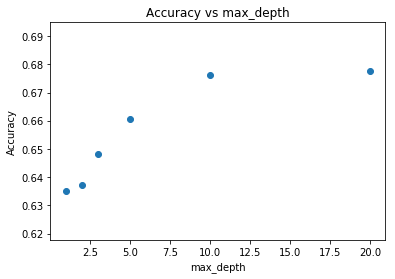

In [20]:
plot_score_dependence(rfgrid, 'max_depth')

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


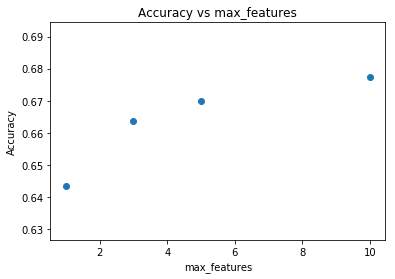

In [21]:
plot_score_dependence(rfgrid, 'max_features')

We now search closer to the best parameters with some manual guessing.  It seems increasing the amount of features seen at each decision may increase accuracy still, but the order of increase for all parameters explored does not seem to be by much.  From the set of best parameters found, the results of minimum samples to consider a split and to be a leaf are found intuitively inconsistent above and likely due to variance: if it did consider a split with only 4 points of data at a node, it could not possibly produce a leaf.  We manually tune for some of these parameters here.

In [43]:
rf = RandomForestClassifier(max_features=1, n_estimators = 30, max_depth=4, min_samples_leaf=1, min_samples_split=2)

In [44]:
rf.fit(xtrain, ytrain)
rf.score(xtrain, ytrain), rf.score(xtest, ytest)

(0.650652557319224, 0.6211640211640211)

We further explore performance along one hyperparameter below, starting with a tree's max_depth.  Here, max_features is set to 1, though we would expect higher performance if we set it higher.  We see that beyond a max_depth of 20, the gains are increasingly modest.  The behavior of the training score is concerning, however; it would be wise to stop increasing max depth arbitrarily.

In [54]:
depths = [1, 5, 10, 20, 30, 50, 100, 150]
scores_test = []
scores_train = []
for depth in depths:
    rf2 = RandomForestClassifier(max_features=5,n_estimators = 30, max_depth=depth, min_samples_leaf=1, min_samples_split=2)
    rf2.fit(xtrain, ytrain)
    scores_test.append(rf2.score(xtest, ytest))
    scores_train.append(rf2.score(xtrain, ytrain))

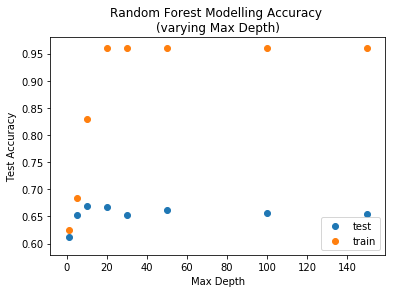

In [55]:
plt.figure()
plt.scatter(depths, scores_test, label='test')
plt.scatter(depths, scores_train, label='train')
plt.xlabel('Max Depth')
plt.ylabel('Test Accuracy')
plt.legend()
plt.title('Random Forest Modelling Accuracy \n(varying Max Depth)');

It seems even with one feature viewed at a time, the max depth should not exceed 5.  Selecting a tree depth of 4, we consider the gains in increasing the number of estimators.  The return seems to level around 20 estimators.  While the training data always scores more than the testing data by a few percentage points in accuracy, this difference does not seem to increase by much as the number of estimators increases.

In [60]:
estimators = [1, 3, 5, 10, 20, 30, 40, 50, 100]
scores_test = []
scores_train = []
for n in estimators:
    rf2 = RandomForestClassifier(max_features=1,n_estimators = n, max_depth=4, min_samples_leaf=1, min_samples_split=2)
    rf2.fit(xtrain, ytrain)
    scores_test.append(rf2.score(xtest, ytest))
    scores_train.append(rf2.score(xtrain, ytrain))

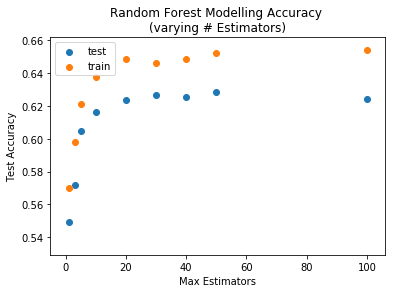

In [62]:
plt.figure()
plt.scatter(estimators, scores_test, label='test')
plt.scatter(estimators, scores_train, label='train')
plt.xlabel('Max Estimators')
plt.ylabel('Test Accuracy')
plt.legend()
plt.title('Random Forest Modelling Accuracy \n(varying # Estimators)');

## Analyzing Feature Importances

No single feature stands out as explaining a larger amount the forest's decisions.  We list the top five vectors ranked by feature importance below.  While there are a few that still list incels specific jargon, others in this list are more general.  We might have some hope that our model will be able to generalize toxic behavior outside of this topic.

In [63]:
names = []
for i in range(len(svd.components_)):
    a = list(zip(svd.components_[i], tf.get_feature_names()))
    a.sort(reverse=True)
    names.append((rf.feature_importances_[i], i, a[:7]))

In [64]:
names.sort(reverse=True)

In [65]:
names[:5]

[(0.0546603439570255,
  1,
  [(0.957120705643408, 'fuck'),
   (0.15851279234387824, 'lol'),
   (0.0634351875061699, 'im'),
   (0.05342665834949385, 'shit'),
   (0.044968039436193034, 'fucking'),
   (0.04314700533778434, 'cope'),
   (0.0316871675744721, 'cuck')]),
 (0.03930137642898656,
  8,
  [(0.6052448450352497, 'people'),
   (0.08615688911613133, 'think'),
   (0.07394548650759505, 'youre'),
   (0.06207694741190467, 'way'),
   (0.059516127744018245, 'make'),
   (0.059321525397606024, 'thats'),
   (0.05421507746095642, 'ugly')]),
 (0.033651968583351025,
  0,
  [(0.30713548815633945, 'just'),
   (0.29351707985847136, 'like'),
   (0.2518358353419466, 'dont'),
   (0.2512337925430378, 'im'),
   (0.23850894611070722, 'people'),
   (0.14555130797474078, 'think'),
   (0.14337188439458307, 'women')]),
 (0.03172864718241373,
  67,
  [(0.42035872774064775, 'said'),
   (0.3747908464534757, 'live'),
   (0.2392463760619274, 'wrong'),
   (0.17539658906465933, 'probably'),
   (0.150811194902756, 'ne

In [66]:
plotme = pd.concat([pd.DataFrame(xtest), ytest.reset_index()], axis=1)

In [67]:
import seaborn as sns

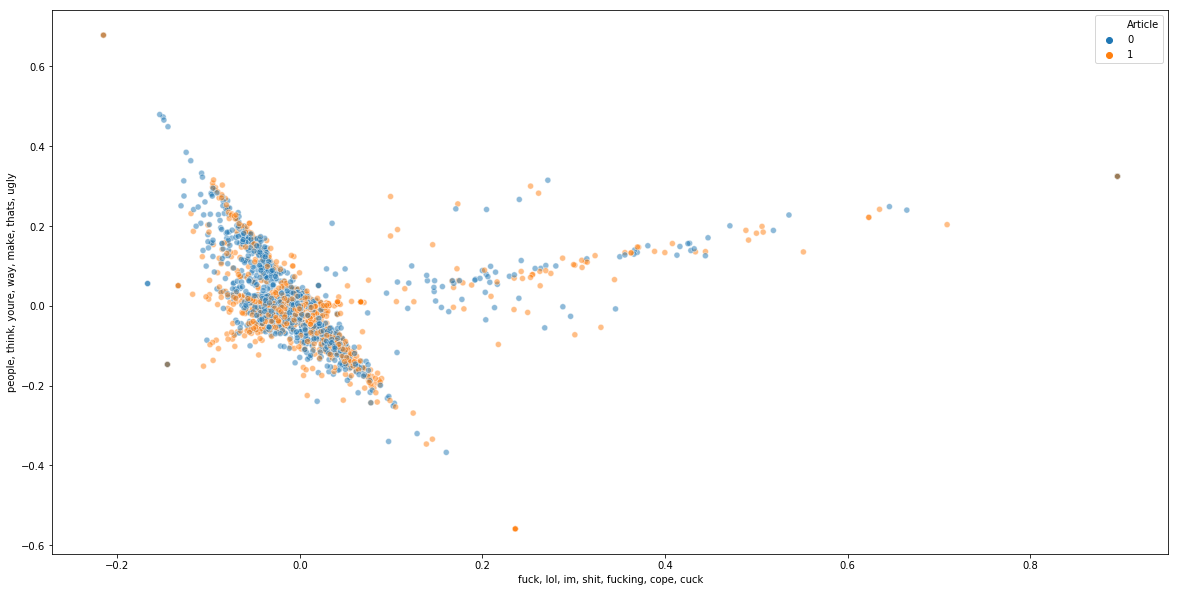

In [69]:
plt.figure(figsize=(20,10))
sns.scatterplot(plotme.columns[2], plotme.columns[3], data=plotme, hue='Article', alpha=0.5)
plt.xlabel(', '.join([element[1] for element in names[0][2]]))
plt.ylabel(', '.join([element[1] for element in names[1][2]]));

It should be reminded that article 1 is from r/incels, 0 from r/foreveralone.  Even in the dimensions that explain the most for single topics, there is very little separation.  There seems to be some in the negative directions for r/incels, which is surprising given the top 5 positive loadings for these topics.  The negative weights for these were not examined, though.

# Conclusions

## Towards a More General Deployment

With an accuracy a little over 60%, we should be hesitant about deploying this as a filter for general use.  In considering whether the results of this filter could possibly be useful, we examine a result which may mislead us to further look down this avenue in developing a general purpose filter, citing the model's predictions on r/changemyview, a more regulated forum that promotes civil discourse. 

In [70]:
files = [f'./jsons/changemyview_comment_{i}.json' for i in range(1)]
pred_coms, lengths = concatCorp(files)
xfinaltest = tf.transform(pred_coms)
testdf = pd.DataFrame(xfinaltest.todense(), columns = tf.get_feature_names())
transformedx = svd.transform(testdf)
np.mean(rf.predict(transformedx))

0.30057165780764217

Using the incels thread as our label of toxic behavior, we see that we are around 70% accurate in avoiding false positives with only the data we have so far.  This is assuming none of the comments from r/changemymind should be at all associated with those in r/incels.  While we would still have a ways to go considering the volume of comments posted on reddit daily, we should remind ourselves the mechanisms used to determine this classification.  First, let us examine a post predicted as not toxic.  We find the third post in our collection to be one of these:

In [71]:
rf.predict([transformedx[2]])

array([0])

In [72]:
pred_coms[2]

'&gt;If I deliberately say "dont hang out with this person if you want me around." there is no difference. \n\nOf course there is.  If you cant see the difference, I cant really help you.'

In [73]:
names = []
for i in range(len(svd.components_)):
    a = list(zip(svd.components_[i], tf.get_feature_names()))
    a.sort(reverse=True)
    names.append((transformedx[2][i], i, a[:7]))

Let us examine the top five projections of this sentence in our topic space produced from fitting to our earlier threads.

In [74]:
names.sort(reverse=True)
names[:5]

[(0.15244491226487922,
  0,
  [(0.30713548815633945, 'just'),
   (0.29351707985847136, 'like'),
   (0.2518358353419466, 'dont'),
   (0.2512337925430378, 'im'),
   (0.23850894611070722, 'people'),
   (0.14555130797474078, 'think'),
   (0.14337188439458307, 'women')]),
 (0.15238632403903077,
  35,
  [(0.5548602398142394, 'say'),
   (0.17996944456168412, 'friends'),
   (0.16957876366481314, 'shit'),
   (0.1612533392402721, 'hes'),
   (0.13778804731512148, 'id'),
   (0.1334237558574386, 'need'),
   (0.12559138691548774, 'didnt')]),
 (0.12067874613442414,
  6,
  [(0.6542139406365304, 'dont'),
   (0.16786879654530437, 'lol'),
   (0.1639513663512268, 'know'),
   (0.13700281498179973, 'want'),
   (0.11838480553098968, 'dont know'),
   (0.11277852580360997, 'people'),
   (0.10109824466770227, 'dont want')]),
 (0.11902503747557593,
  31,
  [(0.4907365863449868, 'really'),
   (0.23473013565676787, 'fucking'),
   (0.22656993674255832, 'time'),
   (0.18542577738989874, 'say'),
   (0.135007549297230

The third item in each tuple are the weights of each word in the topic.  We should note that though the code was lifted from the earlier example examining feature importance, the first item in each tuple is just a projection - it should not immediately be interpreted as something like an importance in decision making.  Still, the point of this display is that the entirety of this sentence projected into our SVD space is simply a single word which drags an entire set of words mostly unrelated to the r/changemyview forum along with it.  This is clear in the second and third items of the list, where "say" potentially drags with it an entire sentiment for the second, and "don't" and "want" drag with it the third.

On a final note, we observe that we have not looked at the corresponding negative terms for each topic.  These would diminish the presence of a topic if the words are found.  We inspect a few of the terms with negative projections just to show the same pattern of detecing one important word.

In [75]:
names = []
for i in range(len(svd.components_)):
    a = list(zip(svd.components_[i], tf.get_feature_names()))
    a.sort()
    names.append((transformedx[2][i], i, a[:7]))

In [76]:
names.sort()
names[:5]

[(-0.07267257788974207,
  19,
  [(-0.29689852371201403, 'fucking'),
   (-0.21593209765326823, 'want'),
   (-0.1723193599641109, 'sex'),
   (-0.16418087497210607, 'post'),
   (-0.13500751370215625, 'say'),
   (-0.12832196787421193, 'know'),
   (-0.12510088104780187, 'right')]),
 (-0.07101942670673628,
  4,
  [(-0.26119645172329153, 'just'),
   (-0.18669698076944238, 'dont'),
   (-0.15148873963284343, 'women'),
   (-0.1274795807067972, 'want'),
   (-0.12717075673506056, 'people'),
   (-0.11633146406533283, 'good'),
   (-0.1152293998410043, 'youre')]),
 (-0.06505604503187933,
  89,
  [(-0.22120838666572273, 'guys'),
   (-0.21755118019175704, 'help'),
   (-0.17072843730727302, 'tbh'),
   (-0.15094447469646266, 'bad'),
   (-0.1449286851550619, 'doesnt'),
   (-0.1362369585035464, 'actually'),
   (-0.1238813755797177, 'tell')]),
 (-0.06338167431916221,
  38,
  [(-0.3597533655519616, 'bro'),
   (-0.30746629429226624, 'got'),
   (-0.2647555822871391, 'say'),
   (-0.25178336212417357, 'hes'),
  

In the first item, the use of the word "want" drags with it a topic we would not identify in this comment.

## More Results From Other Subreddits

Here, we inspect a few more posts that might be associated with r/incels.  Interpreting these results is even more ambiguous than previous, however; it is not necessarily the case that we should claim these are the same types of comments from r/incels.  However, r/truecels was claimed to have been branched from r/incels, and has been banned for this.

In [77]:
def predictIncels(name, n_files):
    files = [f'./jsons/{name}_comment_{i}.json' for i in range(n_files)]
    pred_coms, lengths = concatCorp(files)
    xfinaltest = tf.transform(pred_coms)
    testdf = pd.DataFrame(xfinaltest.todense(), columns = tf.get_feature_names())
    transformedx = svd.transform(testdf)
    return np.mean(rf.predict(transformedx))

In [78]:
predictIncels('truecels', 1)

0.32892690513219286

In [79]:
predictIncels('mensrights', 1)

0.3901705115346038

Neither of these branches is especially close in content to r/incels.  As we have seen with r/changemymind, however, we should not be surprised.  The initial proposition that we might be able to train a model to find general bannable behavior seems to have been defeated.  Before completely dismissing the idea of building a convincing model that can help moderate forums, we might consider the following:

 - Comments were used to build the models here.  However, the actual submission titles and text might also be used to differentiate between communities, and we may see if these posts might also help in classifying comments.
 
 - It is expected that word2vec or doc2vec would do better in recognizing patterns beyond words that occur together (or at least advertised).  As for what we could do here in terms of vocabulary, we could also consider continuing to remove jargon and see if that might generalize to other forums.  This is manually labor intensive, though, and the accuracy obtained probably does not warrant this.
 
 - Examine other parent/banned child subreddit pairs.  While this pair was chosen for the assumption that their content was less tied to the times, we might consider the results we would obtain from altnewz and uncensorednews, which were also obtained.  At the very least, more data can be obtained to refine the model.

Ultimately, what constitutes a community toxic enough to warrant an entire subreddit be banned is subjective.  Even if constituents of a banned subreddit regroup in an attempt to establish a space similar to their previous one, it is not guaranteed our model could continue to detect what warrants a ban as communities evolve.  Still, it is comforting that we have found even some separation between two similar subreddits where one was banned.